# Text Generation using LSTM

This is a small fun project to demonstrate the use of LSTMs in learning text sequences, and thereafter generating new word sequences.

For this activity, we will use a text corpus consisting of Shakespeare's sonnets, which is available at the following link:
https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

The sonnets are just a subset of the entire available corpus. We will train our LSTM based model to learn from these sonnets, and generate poetry of our own! 

In [1]:
# import libraries

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from livelossplot import PlotLossesKerasTF
from IPython.display import SVG, Image
import tensorflow as tf
import tensorflow.keras.utils as ku 
import numpy as np 
import os

In [2]:
# Create Tokenizer object and fit on our corpus
tokenizer = Tokenizer()
data = open('./sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

### Create Model

In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [4]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callback_95 = myCallback()

### Run Model

We will also visualize our model's performance in real time as the number of epochs increase.

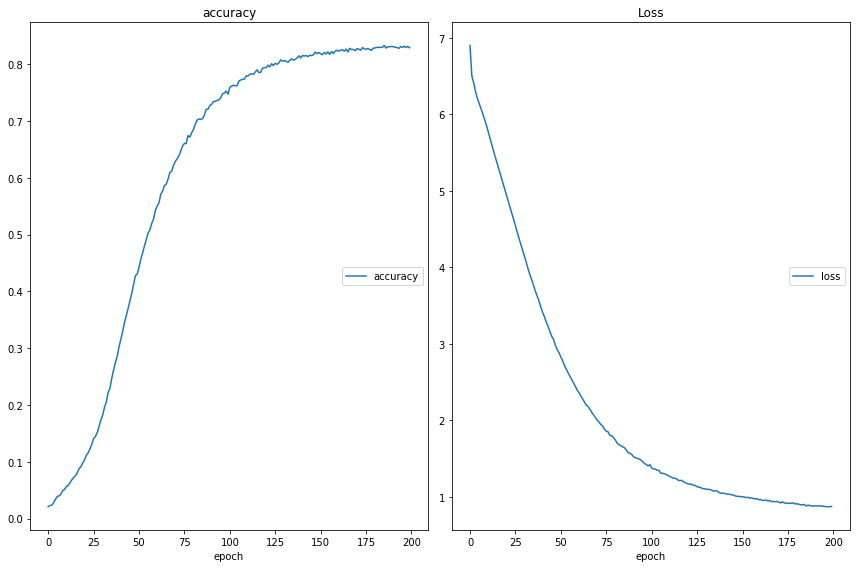

accuracy
	accuracy         	 (min:    0.021, max:    0.833, cur:    0.829)
Loss
	loss             	 (min:    0.869, max:    6.900, cur:    0.872)
484/484 [==============================] - 19s 40ms/step - loss: 0.8716 - accuracy: 0.8293


In [5]:
callbacks = [PlotLossesKerasTF(), callback_95]
history = model.fit(predictors, label, epochs=200, callbacks=callbacks, verbose=1)

Our model has given a training accuracy of ~83%!

We will now try to generate our own Shakespearan poetry, by giving an initial seed text.

In [12]:
seed_text = "Don't be afraid, my friend!"

next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word


In [13]:
seed_text

"Don't be afraid, my friend! shall not another state it is again than quite mother quite shape on you are me in me art time truth do will so ' for love's slave in of life love's days did stand life on laws new autumn are time are love in thee in your eye doth show it me so love thence more are go disgrace in worth that worth doth grew a tongue exchanged way spent shade days at of both at of nor hate hate brow barren of assured things most which now new proud due of fair state fair eyes barren esteem'd than"